In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
valset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


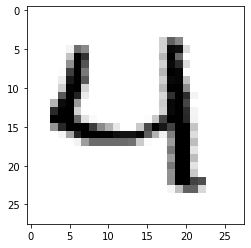

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

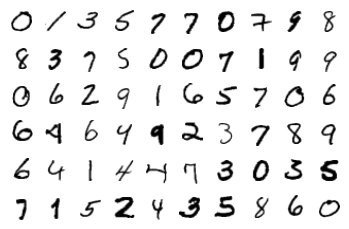

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 3.1561e-05,  3.1561e-05,  3.1561e-05,  ...,  3.1561e-05,
          3.1561e-05,  3.1561e-05],
        [-5.5961e-03, -5.5961e-03, -5.5961e-03,  ..., -5.5961e-03,
         -5.5961e-03, -5.5961e-03],
        [ 7.3171e-06,  7.3171e-06,  7.3171e-06,  ...,  7.3171e-06,
          7.3171e-06,  7.3171e-06],
        ...,
        [-3.2461e-05, -3.2461e-05, -3.2461e-05,  ..., -3.2461e-05,
         -3.2461e-05, -3.2461e-05],
        [ 3.4830e-03,  3.4830e-03,  3.4830e-03,  ...,  3.4830e-03,
          3.4830e-03,  3.4830e-03],
        [ 4.2922e-03,  4.2922e-03,  4.2922e-03,  ...,  4.2922e-03,
          4.2922e-03,  4.2922e-03]])


In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6315914653479926
Epoch 1 - Training loss: 0.28800287523439955
Epoch 2 - Training loss: 0.22290725432145697
Epoch 3 - Training loss: 0.17639435901205297
Epoch 4 - Training loss: 0.14910780287572126
Epoch 5 - Training loss: 0.12702123628162754
Epoch 6 - Training loss: 0.11232513999010423
Epoch 7 - Training loss: 0.10043470386360119
Epoch 8 - Training loss: 0.09094260007079476
Epoch 9 - Training loss: 0.08284616168649958
Epoch 10 - Training loss: 0.07476363794357856
Epoch 11 - Training loss: 0.0690881564606553
Epoch 12 - Training loss: 0.06487157025030935
Epoch 13 - Training loss: 0.059161342421064037
Epoch 14 - Training loss: 0.055636840445031206

Training Time (in minutes) = 6.132627117633819


In [11]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
     

Predicted Digit = 5


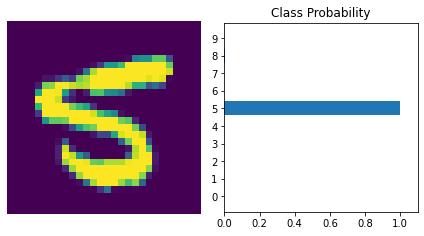

In [44]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)

with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [27]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9771


In [28]:
torch.save(model, './model.pt') 